# Practical n°3: Pixel-scale Prediction - Weakly Supervised Case

## Part II: denoising with FCN - weakly-supervised approaches




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [ ]:
! git clone https://github.com/relmonta/ml-student.git

In [ ]:
! ls

In [ ]:
#On se branche au répertoire contenant utile.py:
os.chdir('ml-student/TP3')

In [ ]:
os.listdir('.')
from utile import *

###Exercise 1: The "noise to noise" scenario

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of independently noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The gen_noise2noise function allows us to sample from both datasets:

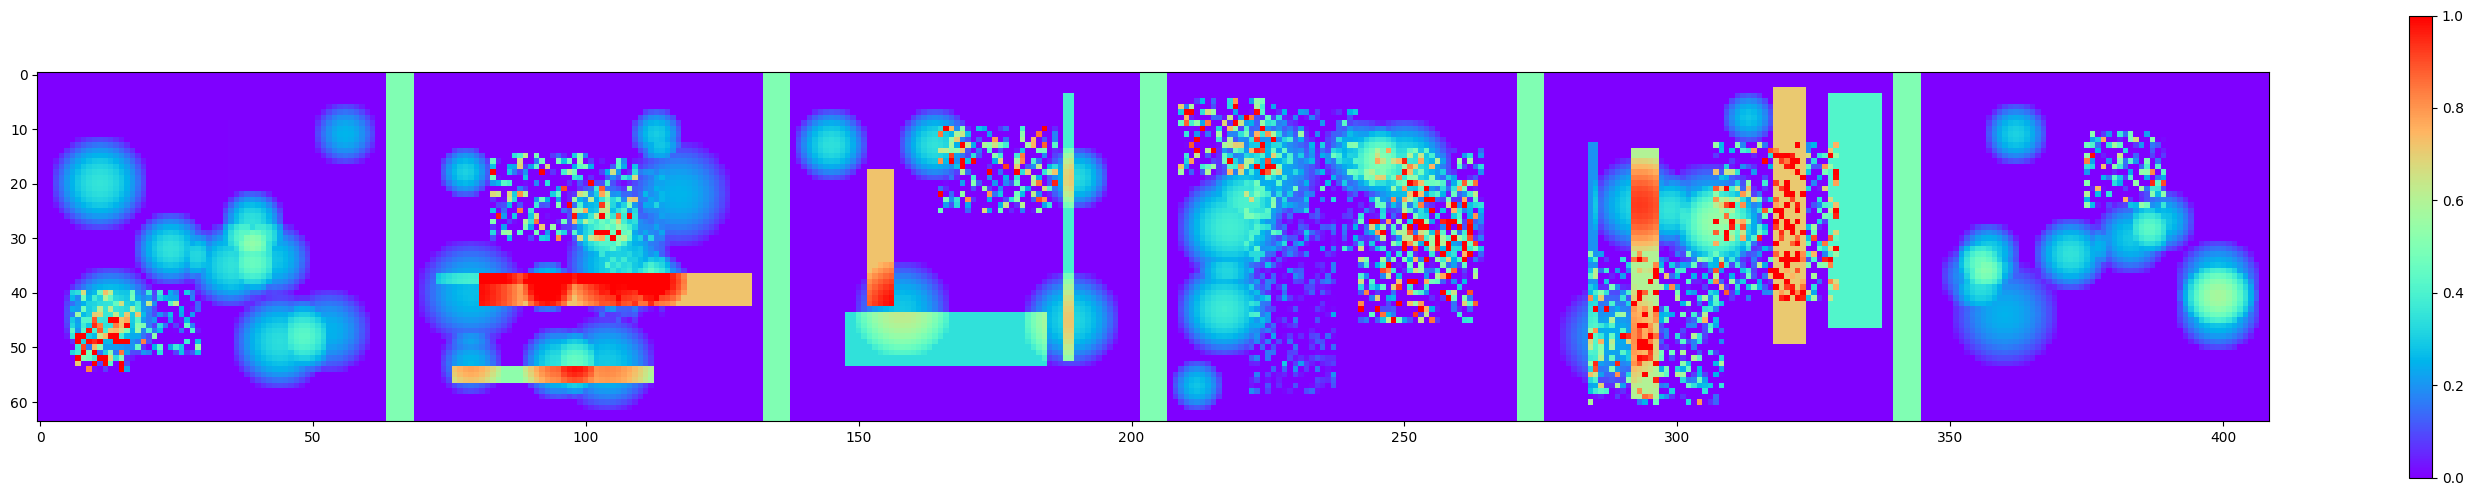

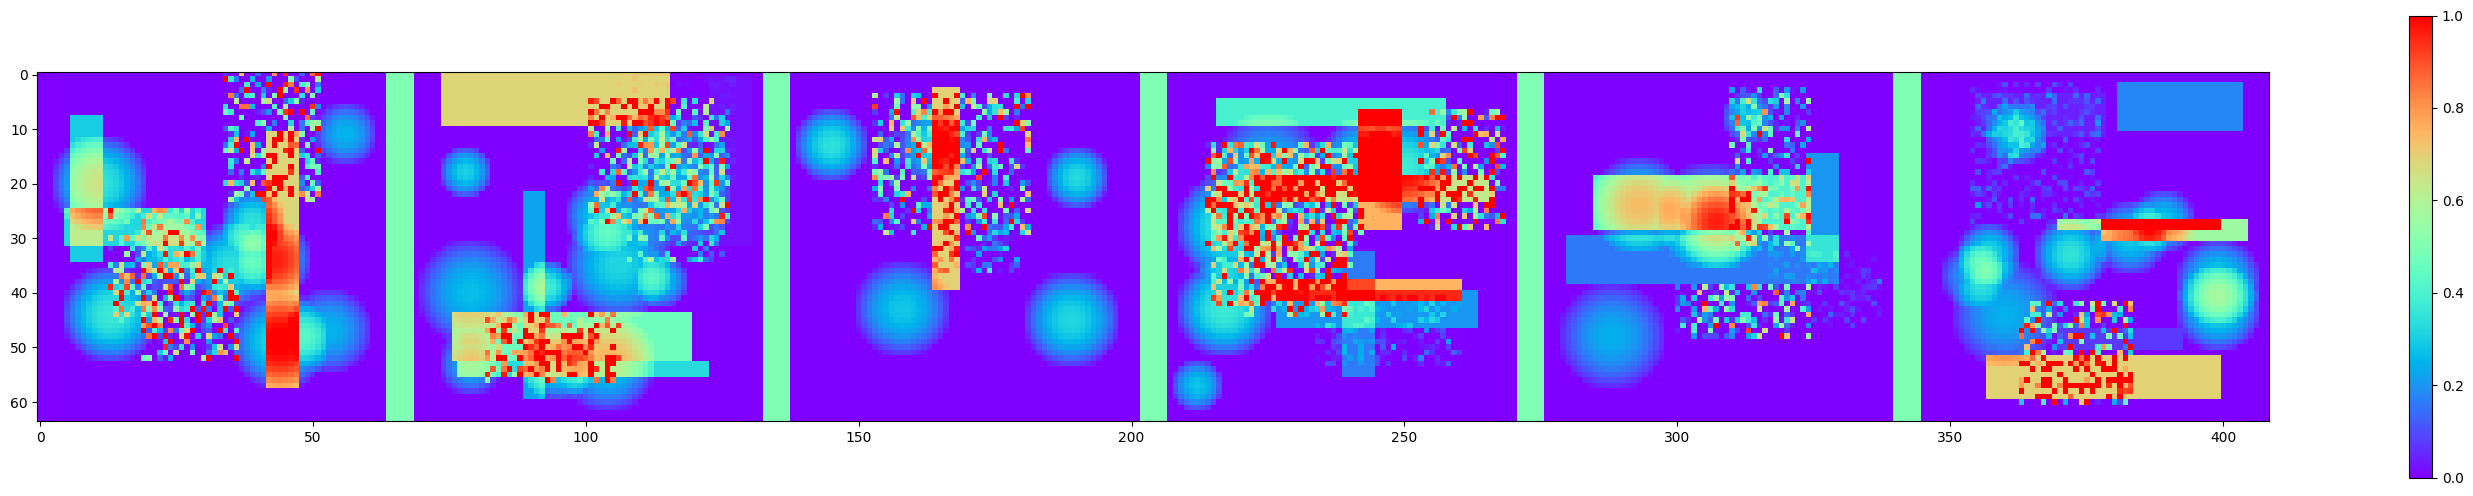

In [ ]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Define a learning procedure that effectively denoises the image.

In [ ]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  ## TODO ##

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_noise2noise(batchsize)

        # go to GPU
        input = ...
        target = ...

        # zeroing gradients, forward pass
        ...

        # loss and compuation of gradients
        ...

        # Update weights
        ...

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

In [ ]:
plt.plot(train_losses)

In [ ]:
# viz:

fcn.eval()
input, target = gen_noise2noise(6)

### TODO ###


**Q2** Theoretical analysis.

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite equation (1) to justify the approach taken for **Q1**.

We rewrite the expectation to be minimized in the case of a cost function equal to the Mean Absolute Error (MAE):

\begin{equation}
 \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] = \mathbb{E}_{X}[ \mathbb{E}_{Y | X}\ |f_\theta(X) - Y | \ ]
\end{equation}

To reach the minimum, the network must provide the conditional median of Y given X . In the case of a quadratic cost function, the network will suggest the conditional expectation. Unlike the median, this is biased, as noise always contribute positively.


###Exercise 2: The "NES" scenario (Neural Egg Separation)

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).



In [ ]:
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample the noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Propose a learning strategy that leads to effective denoising.

**Q2** Discuss the limitations of the method and mention some avenues for improvement.